In [1]:
%%HTML
<script src="require.js"></script>

In [2]:
from IPython.display import display, HTML
HTML(
    """
    <script
        src='https://cdnjs.cloudflare.com/ajax/libs/jquery/2.0.3/jquery.min.js'>
    </script>
    <script>
        code_show=true;
        function code_toggle() {
        if (code_show){
        $('div.jp-CodeCell > div.jp-Cell-inputWrapper').hide();
        } else {
        $('div.jp-CodeCell > div.jp-Cell-inputWrapper').show();
        }
        code_show = !code_show
        }
        $( document ).ready(code_toggle);
    </script>
    <form action='javascript:code_toggle()'>
        <input type="submit" value='Click here to toggle on/off the raw code.'>
    </form>
    """
)

In [44]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error, mean_absolute_error
from catboost import CatBoostRegressor
from surprise import SlopeOne, Dataset, Reader, KNNBaseline, SVD
from sklearn.metrics import ndcg_score

def df_style(df):
    """
    Apply a custom style to the DataFrame's column headers and center the text using HTML and CSS.

    Parameters
    ----------
    df : DataFrame
        The input DataFrame.
    """
    styles = [
        dict(selector="thead th", props=[
            ("background-color", "#29465B"),
            ("color", "white"),
            ("text-align", "center")
        ]),
        dict(selector="th.col_heading", props=[
            ("text-align", "center")
        ]),
        dict(selector="tbody td", props=[
            ("text-align", "center")
        ])
    ]
    
    return df.style.set_table_styles(styles)

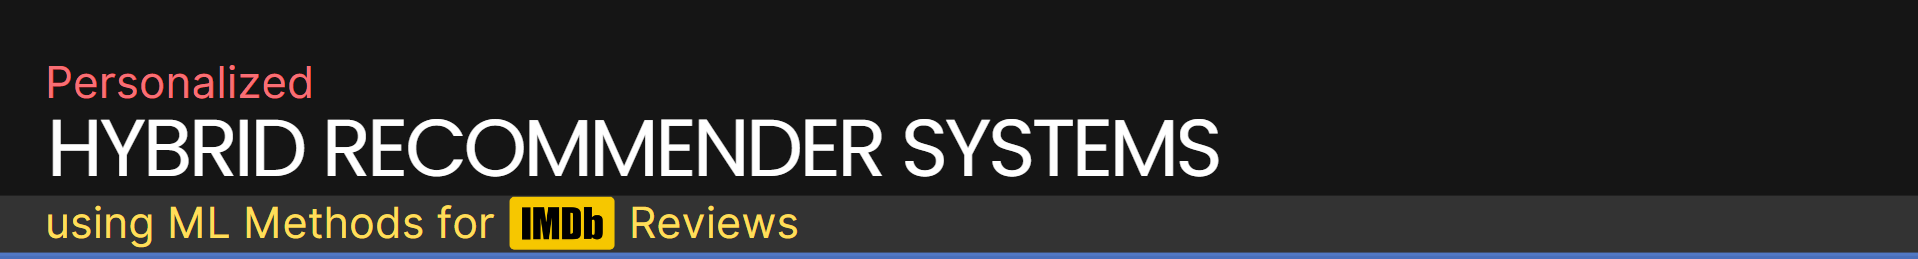

<div style='display: flex; justify-content: space-between; align-items: center; color: #29465B; padding: 10px; width: 100%; border-bottom: 3px solid #29465B'>
    <h3>Table of Contents </h3>
    <style='height: 50px; width: auto; margin-left: auto;'>
</div>

[ref1]: #abstract
[1. Abstract][ref1]

[ref2]: #problem_statement
[2. Problem Statement][ref2]

[ref3]: #motivation
[3. Motivation][ref3]

[ref4]: #data_source
[4. Data Source][ref4]

[ref5]: #methodology
[5. Methodology][ref5]

[ref6]: #movie_clustering
[6. Movie Clustering][ref6]

[ref7]: #hybrid_rec_system
[7. Hybrid Recommender System][ref7]

[ref8]: #results_and_discussion
[8. Results and Discussion][ref8]

[ref9]: #conclusion
[9. Conclusion][ref9]

[ref10]: #recommendations
[10. Recommendations][ref10]

[ref11]: #references
[11. References][ref11]

<a name='abstract'></a>

<div style='display: flex; justify-content: space-between; align-items: center; color: #29465B; padding: 10px; width: 100%; border-bottom: 3px solid #29465B'>
    <h2>1. Abstract </h2>
    <style='height: 50px; width: auto; margin-left: auto;'>
</div>
This project develops a hybrid recommender system using mixed data sources and non-linear machine learning models to predict user movie ratings. The primary data sources include IMDb user movie reviews and a comprehensive movie database. The methodology unfolds in two main stages. Initially, movie data are collected and preprocessed, followed by clustering based on genre tags and release decades using the CLARA algorithm. This organized data is then stored for further processing. In the subsequent stage, user review data is amalgamated with movie clusters and divided into three subsets: one for clustering users and training collaborative filtering (CF) models, another for generating predictions to train the hybrid model, and a final subset for testing and evaluation. User clustering is performed with KMeans, based on review frequencies across movie clusters. Distinct CF models are tailored for specific user and item clusters. These models produce predictions that are combined with those from an ALS model and a naive method, along with additional features, such as the movie's genre and the user's cluster label. The compiled dataset is then used to train a CatBoost model. The efficacy of the hybrid model is evaluated using metrics such as RMSE, MAE, and NDCG. In predicting ratings from 1-10, the hybrid model  surpasses all standalone models and the naive baseline, having achieved an RMSE of 2.2, MAE of 1.7, and NDCG of 0.96. This outcome underscores the advantage of a hybrid approach, combining individual predictions with advanced features to more accurately discern complex user preferences and enhance recommendation accuracy.


<a name='problem_statement'></a>

<div style='display: flex; justify-content: space-between; align-items: center; color: #29465B; padding: 10px; width: 100%; border-bottom: 3px solid #29465B'>
    <h2>2. Problem Statement </h2>
    <style='height: 50px; width: auto; margin-left: auto;'>
</div>

In today's digital age, users are overwhelmed by movie choices, making it difficult to find films that match their preferences. Traditional recommender systems often fall short, struggling to capture the complexity of user tastes.

<b> How can we produce an accurate movie recommender system that leverages mixed data and ML-based models? </b>

This study aims to improve the accuracy of movie recommendations by developing a hybrid recommender system that leverages IMDb reviews and an extensive movie database. By integrating advanced preprocessing methods, clustering techniques, and a combination of collaborative filtering with hybrid models, this research seeks to deliver more precise and personalized movie recommendations.

<a name='motivation'></a>

<div style='display: flex; justify-content: space-between; align-items: center; color: #29465B; padding: 10px; width: 100%; border-bottom: 3px solid #29465B'>
    <h2>3. Motivation </h2>
    <style='height: 50px; width: auto; margin-left: auto;'>
</div>

Traditional recommender systems often fail to capture the intricate nature of user tastes. This project aims to develop a highly accurate hybrid movie recommender system to enhance user satisfaction and demonstrate the effectiveness of advanced data mining techniques in improving recommendation accuracy.

<a name='data_source'></a>

<div style='display: flex; justify-content: space-between; align-items: center; color: #29465B; padding: 10px; width: 100%; border-bottom: 3px solid #29465B'>
    <h2>4. Data Source</h2>
    <style='height: 50px; width: auto; margin-left: auto;'>
</div>

Source: [Kaggle: IMDb Review Dataset](https://www.kaggle.com/datasets/ebiswas/imdb-review-dataset) <br></br>
*The dataset is collected from IMDb and each individual data is publically available. The dataset contains 5.5 million reviews. All rights reserved to IMDb and the user who spent valuable time providing reviewers.*

<br></br>
<center><b>Table 1. Data Overview</b></center>
<center>
<table>
    <thead>
        <tr style="background-color: #29465B; color: white;">
            <th>Column</th>
            <th>Type</th>
            <th>Description</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td>review_id</td>
            <td>int</td>
            <td>It is generated by IMDb and unique to each review</td>
        </tr>
        <tr>
            <td>reviewer</td>
            <td>str</td>
            <td>Public identity or username of the reviewer</td>
        </tr>
        <tr>
            <td>movie</td>
            <td>str</td>
            <td>It represents the name of the show (can be - movie, tv-series, etc.)</td>
        </tr>
        <tr>
            <td>rating</td>
            <td>float</td>
            <td>Rating of movie out of 10, can be None for older reviews</td>
        </tr>
        <tr>
            <td>review_summary</td>
            <td>str</td>
            <td>Plain summary of the review</td>
        </tr>
        <tr>
            <td>review_date</td>
            <td>date</td>
            <td>Date of the posted review</td>
        </tr>
        <tr>
            <td>spoiler_tag</td>
            <td>int</td>
            <td>If 1 = spoiler & 0 = not spoiler</td>
        </tr>
        <tr>
            <td>review_detail</td>
            <td>str</td>
            <td>Details of the review</td>
        </tr>
        <tr>
            <td>helpful</td>
            <td>list</td>
            <td>list[0] people find the review helpful out of list[1]</td>
        </tr>
    </tbody>
</table>
</center>

<a name='methodology'></a>

<div style='display: flex; justify-content: space-between; align-items: center; color: #29465B; padding: 10px; width: 100%; border-bottom: 3px solid #29465B'>
    <h2>5. Methodology</h2>
    <style='height: 50px; width: auto; margin-left: auto;'>
</div>
<br></br>
<center><b>Table 2. Movie Clustering </b></center>
<center>
<table>
    <thead>
        <tr style="background-color: #29465B; color: white;">
            <th>Stage:</th>
            <th>Step</th>
            <th>Description</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td>Load Data</td>
            <td></td>
            <td>Retrieve and load movie data from Kaggle</td>
        </tr>
        <tr>
            <td>Data Cleaning</td>
            <td></td>
            <td>Handle incorrect values, drop duplicates, and filter</td>
        </tr>
        <tr>
            <td>Clustering</td>
            <td></td>
            <td>Using CLARA, perform categorical clustering using genre tags and the film's decade</td>
        </tr>
        <tr>
            <td>Save Data</td>
            <td></td>
            <td>Store the data to df_movie_cat and save to a .csv file</td>
        </tr>
    </tbody>
</table>
</center>



<center><b>Table 3. Hybrid Recommender System</b></center>
<center>
<table>
    <thead>
        <tr style="background-color: #29465B; color: white;">
            <th>Stage</th>
            <th>Step</th>
            <th>Description</th>
        </tr>
    </thead>
    <tbody>
        <tr style="background-color: #f2f2f2;">
            <td rowspan="2">Data Preparation</td>
            <td>I</td>
            <td>Load and clean movie review data and join with <i>df_movie_cat</i> on the film title and year, filtering for users with at least five reviews. Split the resulting dataset into three partitions.</td>
        </tr>
        <tr style="background-color: #f2f2f2;"></tr>
        <tr style="background-color: #ffffff;">
            <td rowspan="5">Partition 1. User Clustering and CF Training</td>
            <td>I</td>
            <td>Create a relative frequency table of each user's review count by movie cluster.</td>
        </tr>
        <tr style="background-color: #ffffff;">
            <td>II</td>
            <td>Cluster users using KMeans and choose optimal clusters.</td>
        </tr>
        <tr style="background-color: #ffffff;"></tr>
        <tr style="background-color: #ffffff;">
            <td>III</td>
            <td>Fit individual CF (Collaborative Filtering) models for each user cluster subset.</td>
        </tr>
        <tr style="background-color: #ffffff;">
            <td>V</td>
            <td>Fit individual CF models for each item cluster subset.</td>
        </tr>
        <tr style="background-color: #f2f2f2;">
            <td rowspan="2">Partition 2. Hybrid Model Training</td>
            <td>I</td>
            <td>Using the trained models from Partition 1, produce predictions using Partition 2 data.</td>
        </tr>
        <tr style="background-color: #f2f2f2;">
            <td>II</td>
            <td>Use Partition 2 data to train the hybrid model.</td>
        </tr>
        <tr style="background-color: #ffffff;">
            <td rowspan="2">Partition 3. Hybrid Model Testing</td>
            <td>I</td>
            <td>Using the pretrained individual models, create predictions using Partition 3 data.</td>
        </tr>
        <tr style="background-color: #ffffff;">
            <td>II</td>
            <td>Using these predictions as well as categorical variables, produce predictions of the hybrid model on Partition 3 data.</td>
        </tr>
        <tr style="background-color: #f2f2f2;">
            <td rowspan="2">Evaluation</td>
            <td>I</td>
            <td>Compare predicted values with actual values and extract RMSE (Root Mean Square Error), MAE (Mean Absolute Error), and NDCG (Normalized Discounted Cumulative Gain).</td>
        </tr>
        <tr style="background-color: #f2f2f2;">
            <td>II</td>
            <td>Evaluate the model's performance.</td>
        </tr>
    </tbody>
</table>
</center>


<a name='movie_clustering'></a>

<div style='display: flex; justify-content: space-between; align-items: center; color: #29465B; padding: 10px; width: 100%; border-bottom: 3px solid #29465B'>
    <h2>6. Movie Clustering</h2>
    <style='height: 50px; width: auto; margin-left: auto;'>
</div>

This section is in separate notebook named `0_IMDB_movieclustering`. It  starts with loading data from Kaggle. The next step involves cleaning the data by handling incorrect values, removing duplicates, and applying filters. Clustering is then performed using the CLARA algorithm, which categorizes movies based on genre tags and the film's decade. The clustered data is then stored in df_movie_cat and saved as a csv file.

<a name='hybrid_rec_system'></a>

<div style='display: flex; justify-content: space-between; align-items: center; color: #29465B; padding: 10px; width: 100%; border-bottom: 3px solid #29465B'>
    <h2>7. Hybrid Recommender System</h2>
    <style='height: 50px; width: auto; margin-left: auto;'>
</div>

This section outlines the creation and evaluation of a hybrid recommender system. It involves preparing and splitting movie review data, clustering users with KMeans, and fitting collaborative filtering models for user and item clusters. Predictions are generated and the hybrid model is trained using these predictions. Lastly, the system's performance is evaluated using RMSE, MAE, and NDCG metrics.

<div style='display: flex; justify-content: space-between; align-items: center; color: #29465B; padding: 10px; width: 100%; border-bottom: 3px solid #29465B'>
    <h3>7.1 Data Preparation</h3>
    <style='height: 50px; width: auto; margin-left: auto;'>
</div>

<div style='display: flex; justify-content: space-between; align-items: center; color: #29465B; width: 100%'>
    <h4>7.1.1 Load Movie Review Dataset</h4>
    <style='height: 50px; width: auto; margin-left: auto;'>
</div>

Load movie review data.

<left>
    <h5>Table 4. Movie Review Dataset</h5>
</left>

In [46]:
df = pd.read_csv('imdb_reviews.zip')
df_style(df.head())

,reviewer,movie,rating,year
0,welhof1,Runaway Train,7.000000,1985
1,andrewtschroeder,Closure (I),9.000000,2018
2,UniqueParticle,Unstoppable,8.000000,2010
3,Pairic,Some Kind of Hate,7.000000,2015
4,Stay_away_from_the_Metropol,Carne,8.000000,1991


In [47]:
print(f'The movie review dataset has {df.shape[0]} reviews')

The movie review dataset has 2436765 reviews


<div style='display: flex; justify-content: space-between; align-items: center; color: #29465B; width: 100%'>
    <h4>7.1.2 Data Cleaning</h4>
    <style='height: 50px; width: auto; margin-left: auto;'>
</div>

During the data cleaning process, the reviews dataset was checked for null values, and none were found.

In [6]:
df.isna().sum()

reviewer    0
movie       0
rating      0
year        0
dtype: int64

However, there are 101 duplicates.

In [7]:
df[df.duplicated(keep=False)].shape[0]

101

<left>
    <h5>Table 5. Movie Review Dataset Duplicates</h5>
</left>

In [8]:
df_style(df[df.duplicated(keep=False)].head())

,reviewer,movie,rating,year
97376,XweAponX,Star Trek: Voyager: Dark Frontier,10.000000,1999
97384,XweAponX,Star Trek: Voyager: Dark Frontier,10.000000,1999
111355,bevo-13678,The Block: Front Garden & Facade Week,10.000000,2020
111357,bevo-13678,The Block: Hallway Week,10.000000,2020
111358,bevo-13678,The Block: Hallway Week,10.000000,2020


Hence, duplicates were removed to eliminate redundancy and prevent bias in the results.

In [9]:
df = df[~df.drop("rating", axis=1).duplicated(keep="last")]

df = df.where(
    df.reviewer.isin(
        df.groupby("reviewer")
        .size()
        .to_frame("a")
        .query("a >= 5")
        .index.tolist()
    )
).dropna()

print('Number of Duplicates for each column:')
df[df.duplicated(keep=False)].count()

Number of Duplicates for each column:


reviewer    0
movie       0
rating      0
year        0
dtype: int64

<div style='display: flex; justify-content: space-between; align-items: center; color: #29465B; width: 100%'>
    <h4>7.1.3 Load movie categories</h4>
    <style='height: 50px; width: auto; margin-left: auto;'>
</div>

Load the generated movie categories from movie clustering.

<left>
    <h5>Table 6. Generated Movie Categories</h5>
</left>

In [10]:
df_m = pd.read_csv("df_movies_cat.csv")
df_m.rename(columns={"movie_name": "movie"}, inplace=True)
df_m = df_m[["movie", "year", "cluster"]].drop_duplicates()
df_style(df_m.head())

,movie,year,cluster
0,Black Panther: Wakanda Forever,2022,1
1,Avatar: The Way of Water,2022,1
2,Plane,2023,1
3,Everything Everywhere All at Once,2022,1
4,Fast X,2023,37


<div style='display: flex; justify-content: space-between; align-items: center; color: #29465B; width: 100%'>
    <h4>7.1.4 Join datasets</h4>
    <style='height: 50px; width: auto; margin-left: auto;'>
</div>

Join `movie review dataset` with the movie clusters, `df_movie_cat`.

<left>
    <h5>Table 7. Movie Reviews Combined with Corresponding Movie Category</h5>
</left>

In [11]:
df = df.merge(df_m)
df["movie"] = (
    df["movie"]
    + "-"
    + df["year"].astype(str)
    + "-"
    + df["cluster"].astype(str)
)
df_style(df.head())

,reviewer,movie,rating,year,cluster
0,welhof1,Runaway Train-1985.0-34,7.000000,1985.000000,34
1,UniqueParticle,Unstoppable-2010.0-0,8.000000,2010.000000,0
2,Pairic,Some Kind of Hate-2015.0-3,7.000000,2015.000000,3
3,vostf,500 Days of Summer-2009.0-2,5.000000,2009.000000,2
4,westsideschl,Sonic the Hedgehog-2020.0-1,3.000000,2020.000000,1


<div style='display: flex; justify-content: space-between; align-items: center; color: #29465B; width: 100%'>
    <h4>7.1.5 Split the data</h4>
    <style='height: 50px; width: auto; margin-left: auto;'>
</div>

The data is split into `train`, `val`, and `test`. KMeans clustering is then used on the `train` data to find the user clusters. The user cluster labels are then applied to all 3 partitions.

In [12]:
X_trainval, X_test, y_trainval, y_test = train_test_split(
    df.drop("rating", axis=1), df.rating, test_size=0.2, random_state=1337
)

X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=0.25, random_state=1337
)
del df, df_m, X_trainval, y_trainval

<div style='display: flex; justify-content: space-between; align-items: center; color: #29465B; padding: 10px; width: 100%; border-bottom: 3px solid #29465B'>
    <h3>7.2 Partition 1. User Clustering and CF Training </h3>
    <style='height: 50px; width: auto; margin-left: auto;'>
</div>

To create a relative frequency table, a frequency table was first generated from partition 1 using a pivot table. This pivot table provides insights into the distribution of clusters among reviewers in the training dataset. By aggregating the data and filling missing values with zeros, it ensures each reviewer's interaction with each cluster is accounted for, even if some clusters have no reviews from certain reviewers.

<center>
    <h5>Table 8. Frequency Table</h5>
</center>

In [13]:
df_user_mc = X_train.pivot_table(
    index="reviewer", columns="cluster", aggfunc="size", fill_value=0
)
df_style(df_user_mc.head())

cluster,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49
reviewer,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
!@N,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
"""Joker""",0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
"""boz""",0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
#1 Gracie,0,0,6,0,0,0,3,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
$thing,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


<div style='display: flex; justify-content: space-between; align-items: center; color: #29465B; width: 100%'>
    <h4>7.2.1 Relative Frequency Table </h4>
    <style='height: 50px; width: auto; margin-left: auto;'>
</div>

Afterwards, the relative frequency table was created by normalizing the frequency table. Each reviewer's cluster counts were divided by their total number of reviews to obtain proportional values.

<center>
    <h5>Table 9. Relative Frequency Table</h5>
</center>

In [14]:
df_user_mc = df_user_mc.div(df_user_mc.sum(axis=1), axis=0)
df_style(df_user_mc.head())

cluster,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49
reviewer,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
!@N,0.000000,0.000000,0.333333,0.000000,0.333333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.333333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
"""Joker""",0.000000,0.000000,0.000000,0.250000,0.000000,0.000000,0.000000,0.000000,0.250000,0.000000,0.000000,0.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
"""boz""",0.000000,0.000000,0.000000,0.000000,0.333333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.333333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.333333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
#1 Gracie,0.000000,0.000000,0.545455,0.000000,0.000000,0.000000,0.272727,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.090909,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.090909,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
$thing,0.000000,0.000000,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


<div style='display: flex; justify-content: space-between; align-items: center; color: #29465B; width: 100%'>
    <h4>7.2.2 User Clustering </h4>
    <style='height: 50px; width: auto; margin-left: auto;'>
</div>

Users were clustered based on their review patterns using the KMeans algorithm. The number of clusters was set by dividing the number of users by 5000. Consequently, the resulting clusters were combined with reviewer identifiers into a new DataFrame.

<left>
    <h5>Table 10. User Clusters</h5>
</left>

In [15]:
kmeans = KMeans(df_user_mc.shape[0] // 5000, random_state=1337)
df_user_cat = pd.concat(
    [
        df_user_mc.index.to_frame().reset_index(drop=True),
        pd.Series(kmeans.fit_predict(df_user_mc)),
    ],
    axis=1,
    ignore_index=True,
)
df_user_cat.rename(columns={0: "reviewer", 1: "user_cat"}, inplace=True)

del df_user_mc, kmeans
df_style(df_user_cat.head())

,reviewer,user_cat
0,!@N,12
1,"""Joker""",8
2,"""boz""",12
3,#1 Gracie,11
4,$thing,0


User cluster information was merged into the training, validation, and test datasets to enhance analysis and recommendations.

<left>
    <h5>Table 11. Training (Partition 1) Dataset with Corresponding User Category</h5>
</left>

In [16]:
X_train = (
    X_train.reset_index().merge(df_user_cat, on="reviewer").set_index("index")
)
X_val = (
    X_val.reset_index().merge(df_user_cat, on="reviewer").set_index("index")
)
y_val = y_val[X_val.index]
X_test = (
    X_test.reset_index().merge(df_user_cat, on="reviewer").set_index("index")
)
y_test = y_test[X_test.index]

df_style(X_train.head())

,reviewer,movie,year,cluster,user_cat
index,,,,,
579466,gcd70,Nine Months-1995.0-14,1995.000000,14,7
731080,evoid,Kill Bill: Vol. 1-2003.0-43,2003.000000,43,4
444095,SamJamie,Before I Go to Sleep-2014.0-26,2014.000000,26,11
367498,DennisBergkamp10,The Platform-2019.0-38,2019.000000,38,16
1048738,drakula2005,Shattered-2007.0-2,2007.000000,2,11


<div style='display: flex; justify-content: space-between; align-items: center; color: #29465B; width: 100%'>
    <h4>7.2.3 Fit individual CF models for each user cluster subset </h4>
    <style='height: 50px; width: auto; margin-left: auto;'>
</div>

The various recommender systems are fitted on the `train` data. 

<br></br>
<center><b>Table 12. Recommender Systems Overview</b></center>
<center>
<table>
    <thead>
        <tr style="background-color: #29465B; color: white;">
            <th>Type</th>
            <th>Model</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td>baseline</td>
            <td>mean rating per movie</td>
        </tr>
        <tr>
            <td>matrix factorization</td>
            <td>SVD</td>
        </tr>
        <tr>
            <td>user-based</td>
            <td>KNN</td>
        </tr>
        <tr>
            <td>item-based</td>
            <td>SlopeOne</td>
        </tr>
    </tbody>
</table>
</center>

<div style='display: flex; justify-content: space-between; align-items: center; color: #29465B; width: 100%'>
    <h5>7.2.3.1 Baseline</h5>
    <style='height: 50px; width: auto; margin-left: auto;'>
</div>

In [17]:
# Calculate the average rating for each movie
bl = X_train.join(y_train).groupby("movie")["rating"].mean().reset_index()

# Merge the baseline ratings back into the training data
y_bl_train = X_train.reset_index().merge(bl).set_index("index").rating

<div style='display: flex; justify-content: space-between; align-items: center; color: #29465B; width: 100%'>
    <h5>7.2.3.2 Preparation of the 3 Partitions for CF training</h5>
    <style='height: 50px; width: auto; margin-left: auto;'>
</div>

To prepare the datasets for a collaborative filtering model, a Reader object was initialized with a rating scale from 1 to 10. The training set was created by joining and loading the reviewer, movie, and rating data. Similarly, the validation set was prepared and converted into a test set for validation, and the test set was prepared and converted into a test set for evaluation.

In [18]:
# Reader initialization with rating scale
reader = Reader(rating_scale=(1, 10))

# Training set preparation
trainset = Dataset.load_from_df(
    X_train.join(y_train)[["reviewer", "movie", "rating"]], reader
).build_full_trainset()

# Validation set preparation
valset = (
    Dataset.load_from_df(
        X_val.join(y_val)[["reviewer", "movie", "rating"]], reader
    )
    .build_full_trainset()
    .build_testset()
)

# Test set preparation
testset = (
    Dataset.load_from_df(
        X_test.join(y_test)[["reviewer", "movie", "rating"]], reader
    )
    .build_full_trainset()
    .build_testset()
)

<div style='display: flex; justify-content: space-between; align-items: center; color: #29465B; width: 100%'>
    <h5>7.2.3.3 SVD Model</h5>
    <style='height: 50px; width: auto; margin-left: auto;'>
</div>

In [19]:
svd = SVD()
svd.fit(trainset)

predictions = svd.test(trainset.build_testset())
y_pred = []
for prediction in predictions:
    uid, iid, _, est, _ = prediction
    y_pred.append({"reviewer": uid, "movie": iid, "mfactor": est})
X_train = X_train.reset_index().merge(pd.DataFrame(y_pred)).set_index("index")

<div style='display: flex; justify-content: space-between; align-items: center; color: #29465B; width: 100%'>
    <h5>7.2.3.4 kNN Model</h5>
    <style='height: 50px; width: auto; margin-left: auto;'>
</div>

In [20]:
knn = {}
y_pred = []
for i in range(X_train.user_cat.nunique()):
    knn[i] = KNNBaseline(verbose=False)
    data = Dataset.load_from_df(
        X_train.join(y_train).query("user_cat == @i")[
            ["reviewer", "movie", "rating"]
        ],
        reader,
    ).build_full_trainset()
    knn[i].fit(data)

    predictions = knn[i].test(data.build_testset())
    for prediction in predictions:
        uid, iid, _, est, _ = prediction
        y_pred.append({"reviewer": uid, "movie": iid, "user_based": est})

X_train = X_train.reset_index().merge(pd.DataFrame(y_pred)).set_index("index")

<div style='display: flex; justify-content: space-between; align-items: center; color: #29465B; width: 100%'>
    <h5>7.2.3.5 Slope Model</h5>
    <style='height: 50px; width: auto; margin-left: auto;'>
</div>

In [21]:
s1 = {}
y_pred = []
for i in range(X_train.cluster.nunique()):
    s1[i] = SlopeOne()
    data = Dataset.load_from_df(
        X_train.join(y_train).query("cluster == @i")[
            ["reviewer", "movie", "rating"]
        ],
        reader,
    ).build_full_trainset()
    s1[i].fit(data)

    predictions = s1[i].test(data.build_testset())
    for prediction in predictions:
        uid, iid, _, est, _ = prediction
        y_pred.append({"reviewer": uid, "movie": iid, "item_based": est})

X_train = X_train.reset_index().merge(pd.DataFrame(y_pred)).set_index("index")

<left>
    <h5>Table 13. Train Dataset with Different Models' Predictions</h5>
</left>

In [22]:
del data, predictions, y_pred, trainset
df_style(X_train.head())

,reviewer,movie,year,cluster,user_cat,mfactor,user_based,item_based
index,,,,,,,,
579466,gcd70,Nine Months-1995.0-14,1995.000000,14,7,4.555275,4.613320,4.943548
731080,evoid,Kill Bill: Vol. 1-2003.0-43,2003.000000,43,4,6.883350,7.034011,7.000000
444095,SamJamie,Before I Go to Sleep-2014.0-26,2014.000000,26,11,6.837722,7.321374,7.000000
367498,DennisBergkamp10,The Platform-2019.0-38,2019.000000,38,16,5.797813,6.001158,6.000000
1048738,drakula2005,Shattered-2007.0-2,2007.000000,2,11,7.672252,8.194335,7.250000


<div style='display: flex; justify-content: space-between; align-items: center; color: #29465B; padding: 10px; width: 100%; border-bottom: 3px solid #29465B'>
    <h3>7.3 Partition 2. Hybrid Model Training</h3>
    <style='height: 50px; width: auto; margin-left: auto;'>
</div>

The CatBoostRegressor is trained using the predictions of the recommender systems on the `val` data. Included in the training features are the reviewer, movie, user cluster, and movie cluster as categorical features. The movie's year of release is also included as a numerical feature.

In [23]:
y_pred = []
predictions = svd.test(valset)
for prediction in predictions:
    uid, iid, _, est, _ = prediction
    y_pred.append({"reviewer": uid, "movie": iid, "mfactor": est})
X_val = X_val.reset_index().merge(pd.DataFrame(y_pred)).set_index("index")

In [24]:
y_pred = []
for i in range(X_train.user_cat.nunique()):
    data = (
        Dataset.load_from_df(
            X_val.join(y_val).query("user_cat == @i")[
                ["reviewer", "movie", "rating"]
            ],
            reader,
        )
        .build_full_trainset()
        .build_testset()
    )

    predictions = knn[i].test(data)
    for prediction in predictions:
        uid, iid, _, est, _ = prediction
        y_pred.append({"reviewer": uid, "movie": iid, "user_based": est})

X_val = X_val.reset_index().merge(pd.DataFrame(y_pred)).set_index("index")

In [25]:
y_pred = []
for i in range(X_train.cluster.nunique()):
    data = (
        Dataset.load_from_df(
            X_val.join(y_val).query("cluster == @i")[
                ["reviewer", "movie", "rating"]
            ],
            reader,
        )
        .build_full_trainset()
        .build_testset()
    )

    predictions = s1[i].test(data)
    for prediction in predictions:
        uid, iid, _, est, _ = prediction
        y_pred.append({"reviewer": uid, "movie": iid, "item_based": est})

X_val = X_val.reset_index().merge(pd.DataFrame(y_pred)).set_index("index")

In [26]:
cbr = CatBoostRegressor(random_state=1337, eval_metric="MAE")
cbr.fit(
    X_val,
    y_val,
    cat_features=["reviewer", "movie", "cluster", "user_cat"],
)

Learning rate set to 0.097815
0:	learn: 2.1556201	total: 193ms	remaining: 3m 12s
1:	learn: 2.0965668	total: 305ms	remaining: 2m 32s
2:	learn: 2.0463491	total: 412ms	remaining: 2m 16s
3:	learn: 2.0045476	total: 520ms	remaining: 2m 9s
4:	learn: 1.9717423	total: 618ms	remaining: 2m 3s
5:	learn: 1.9437422	total: 705ms	remaining: 1m 56s
6:	learn: 1.9185264	total: 794ms	remaining: 1m 52s
7:	learn: 1.8973941	total: 883ms	remaining: 1m 49s
8:	learn: 1.8790043	total: 973ms	remaining: 1m 47s
9:	learn: 1.8622762	total: 1.05s	remaining: 1m 44s
10:	learn: 1.8474011	total: 1.16s	remaining: 1m 43s
11:	learn: 1.8350717	total: 1.25s	remaining: 1m 43s
12:	learn: 1.8239567	total: 1.36s	remaining: 1m 43s
13:	learn: 1.8149089	total: 1.44s	remaining: 1m 41s
14:	learn: 1.8066971	total: 1.52s	remaining: 1m 39s
15:	learn: 1.7999068	total: 1.61s	remaining: 1m 38s
16:	learn: 1.7935431	total: 1.69s	remaining: 1m 37s
17:	learn: 1.7881001	total: 1.78s	remaining: 1m 37s
18:	learn: 1.7833195	total: 1.87s	remaining: 1

<div style='display: flex; justify-content: space-between; align-items: center; color: #29465B; padding: 10px; width: 100%; border-bottom: 3px solid #29465B'>
    <h3>7.4 Partition 3. Hybrid Model Testing</h3>
    <style='height: 50px; width: auto; margin-left: auto;'>
</div>

All the recommender systems and hybrid models are tested and evaluated on the `test` data using RMSE, MAE, and NCDG as the metrics.

In [27]:
y_bl = X_test.reset_index().merge(bl).set_index("index").rating
y_bl = (y_bl + y_test - y_test).fillna(bl.rating.mean())[y_test.index]

In [28]:
y_pred = []
predictions = svd.test(testset)
for prediction in predictions:
    uid, iid, _, est, _ = prediction
    y_pred.append({"reviewer": uid, "movie": iid, "mfactor": est})
X_test = X_test.reset_index().merge(pd.DataFrame(y_pred)).set_index("index")

In [29]:
y_pred = []
for i in range(X_train.user_cat.nunique()):
    data = (
        Dataset.load_from_df(
            X_test.join(y_test).query("user_cat == @i")[
                ["reviewer", "movie", "rating"]
            ],
            reader,
        )
        .build_full_trainset()
        .build_testset()
    )

    predictions = knn[i].test(data)
    for prediction in predictions:
        uid, iid, _, est, _ = prediction
        y_pred.append({"reviewer": uid, "movie": iid, "user_based": est})

X_test = X_test.reset_index().merge(pd.DataFrame(y_pred)).set_index("index")

In [30]:
y_pred = []
for i in range(X_train.cluster.nunique()):
    data = (
        Dataset.load_from_df(
            X_test.join(y_test).query("cluster == @i")[
                ["reviewer", "movie", "rating"]
            ],
            reader,
        )
        .build_full_trainset()
        .build_testset()
    )

    predictions = s1[i].test(data)
    for prediction in predictions:
        uid, iid, _, est, _ = prediction
        y_pred.append({"reviewer": uid, "movie": iid, "item_based": est})

X_test = X_test.reset_index().merge(pd.DataFrame(y_pred)).set_index("index")

<div style='display: flex; justify-content: space-between; align-items: center; color: #29465B; padding: 10px; width: 100%; border-bottom: 3px solid #29465B'>
    <h3>7.5. Evaluation</h3>
    <style='height: 50px; width: auto; margin-left: auto;'>
</div>

All the recommender systems and hybrid models are tested and evaluated on the `test` data using RMSE, MAE, and NCDG as the metrics.

In [31]:
y_pred = cbr.predict(X_test)

reg = LinearRegression(fit_intercept=True, positive=True)
reg.fit(
    X_val[["mfactor", "user_based", "item_based"]],
    y_val,
)
y_reg_train = (reg.coef_ * X_val[["mfactor", "user_based", "item_based"]]).sum(
    axis=1
) + reg.intercept_
y_reg = (reg.coef_ * X_test[["mfactor", "user_based", "item_based"]]).sum(
    axis=1
) + reg.intercept_

model = [
    "Hybrid CatBoost",
    "Hybrid LinearRegression",
    "Baseline",
    "SVD",
    "KNN",
    "SlopeOne",
]
train_rmse = [
    cbr.best_score_["learn"]["RMSE"],
    root_mean_squared_error(y_val, y_reg_train),
    root_mean_squared_error(y_train, y_bl_train),
    root_mean_squared_error(y_train, X_train.mfactor),
    root_mean_squared_error(y_train, X_train.user_based),
    root_mean_squared_error(y_train, X_train.item_based),
]
train_mae = [
    cbr.best_score_["learn"]["MAE"],
    mean_absolute_error(y_val, y_reg_train),
    mean_absolute_error(y_train, y_bl_train),
    mean_absolute_error(y_train, X_train.mfactor),
    mean_absolute_error(y_train, X_train.user_based),
    mean_absolute_error(y_train, X_train.item_based),
]
test_rmse = [
    root_mean_squared_error(y_test, y_pred),
    root_mean_squared_error(y_test, y_reg),
    root_mean_squared_error(y_test, y_bl),
    root_mean_squared_error(y_test, X_test.mfactor),
    root_mean_squared_error(y_test, X_test.user_based),
    root_mean_squared_error(y_test, X_test.item_based),
]
test_mae = [
    mean_absolute_error(y_test, y_pred),
    mean_absolute_error(y_test, y_reg),
    mean_absolute_error(y_test, y_bl),
    mean_absolute_error(y_test, X_test.mfactor),
    mean_absolute_error(y_test, X_test.user_based),
    mean_absolute_error(y_test, X_test.item_based),
]

In [35]:
def mean_ndcg(test, pred):
    """Calculate the mean ndcg for the test set"""
    ndcg_ = []
    for i, y in enumerate(test):
        if len(y) > 1:
            ndcg_.append(ndcg_score(np.array([y]), np.array([pred[i]])))
    return np.mean(ndcg_)


ndcg_test = (
    X_test.join(y_test).groupby("reviewer")["rating"].apply(list).tolist()
)

ndcg = [
    mean_ndcg(
        ndcg_test,
        X_test.assign(rating=y_pred)
        .groupby("reviewer")["rating"]
        .apply(np.array)
        .tolist(),
    ),
    mean_ndcg(
        ndcg_test,
        X_test.assign(rating=y_reg)
        .groupby("reviewer")["rating"]
        .apply(np.array)
        .tolist(),
    ),
    mean_ndcg(
        ndcg_test,
        X_test.assign(rating=y_bl)
        .groupby("reviewer")["rating"]
        .apply(np.array)
        .tolist(),
    ),
    mean_ndcg(
        ndcg_test,
        X_test.groupby("reviewer")["mfactor"].apply(np.array).tolist(),
    ),
    mean_ndcg(
        ndcg_test,
        X_test.groupby("reviewer")["user_based"].apply(np.array).tolist(),
    ),
    mean_ndcg(
        ndcg_test,
        X_test.groupby("reviewer")["item_based"].apply(np.array).tolist(),
    ),
]

<left>
    <h5>Table 14. Recommendation System Results</h5>
</left>

In [36]:
results = pd.DataFrame(
    [model, train_rmse, train_mae, test_rmse, test_mae, ndcg]
).T
results.columns = [
    "model",
    "train_rmse",
    "train_mae",
    "test_rmse",
    "test_mae",
    "ndcg",
]
df_style(results)

,model,train_rmse,train_mae,test_rmse,test_mae,ndcg
0,Hybrid CatBoost,2.154201,1.668346,2.174775,1.681903,0.957530
1,Hybrid LinearRegression,2.243558,1.754678,2.241988,1.752636,0.955582
2,Baseline,2.326246,1.829068,2.431732,1.925390,0.957561
3,SVD,0.912499,0.660482,2.290534,1.787223,0.954767
4,KNN,0.741608,0.523024,2.389881,1.843348,0.948305
5,SlopeOne,0.948923,0.519443,2.573082,1.980143,0.942103


<a name='results_and_discussion'></a>

<div style='display: flex; justify-content: space-between; align-items: center; color: #29465B; padding: 10px; width: 100%; border-bottom: 3px solid #29465B'>
    <h2>8. Results and Discussion</h2>
    <style='height: 50px; width: auto; margin-left: auto;'>
</div>

The performance of various recommendation models was evaluated using Root Mean Square Error (RMSE), Mean Absolute Error (MAE), and Normalized Discounted Cumulative Gain (NDCG) on both training and testing datasets derived from the movie reviews and movie dataset and the results are shown in Table 14. <b> The Hybrid CatBoost model demonstrated strong performance across all metrics, achieving a Test RMSE of 2.17 and a Test MAE of 1.68. </b> Additionally, <b>it has the highest NDCG score of 0.9578.</b> These results indicate that Hybrid CatBoost is particularly effective in ranking recommendations accurately and minimizing prediction errors, showcasing its robustness in handling complex interactions between feature.

The Hybrid LinearRegression model also performed well, with a Test RMSE of 2.24 and a Test MAE of 1.75. Its NDCG score was 0.9558, closely following the Hybrid CatBoost model. This model's performance highlights the benefit of integrating linear regression into a hybrid recommendation approach to improve accuracy and ranking.

The Baseline showed higher error metrics, with a Test RMSE of 2.43 and a Test MAE of 1.93. However, it still achieved a competitive NDCG score of 0.9576. This indicates that while its absolute prediction errors were higher, its ability to rank recommendations was relatively strong.

The SVD model had the lowest Train RMSE (0.91) and Train MAE (0.66), suggesting excellent fit to the training data. However, its performance on the test data was less impressive, with a Test RMSE of 2.29 and a Test MAE of 1.79, indicating potential overfitting. Its NDCG score was 0.9549, slightly lower than the hybrid models.

The KNN model demonstrated the lowest Train RMSE (0.74) and Train MAE (0.52), but its performance on the test data was suboptimal, with a Test RMSE of 2.39 and a Test MAE of 1.84. Its NDCG score was 0.9483, reflecting its struggle to generalize well from the training data to the test data.

The SlopeOne model showed the highest Test RMSE (2.5731) and Test MAE (1.98), indicating the most significant prediction errors among the evaluated models. Its NDCG score of 0.9421 was the lowest, further highlighting its poor ranking performance.

<a name='conclusion'></a>

<div style='display: flex; justify-content: space-between; align-items: center; color: #29465B; padding: 10px; width: 100%; border-bottom: 3px solid #29465B'>
    <h2>9. Conclusion</h2>
    <style='height: 50px; width: auto; margin-left: auto;'>
</div>  


The hybrid model in this project achieved impressive metrics, with an RMSE of 2.17 and an MAE of 1.68, outperforming traditional models and the baseline. By integrating user-based and item-based collaborative filtering predictions with additional features using CatBoost, the hybrid model effectively captured complex data patterns. This approach provided more accurate and reliable recommendations, demonstrating the model's superior performance and marking a significant advancement in recommendation systems.   
                                                                                 
Efficiency and scalability were key priorities in this project, achieved through smart tactics like using data subsets and parallel processing. Dividing the data into manageable chunks allowed for handling large volumes without slowing down operations. Parallel processing across multiple resources could boost performance and ensure optimal resource utilization. These strategies not only can enhance scalability to manage increasing data but also optimize efficiency for a more responsive system in the future.
         
However, the cold start issue, particularly for users with less than 5 reviews, presented a significant challenge for the hybrid system. This issue arises because collaborative filtering methods typically rely on user-item interactions to make accurate recommendations. Users with sparse review histories, such as those with less than 5 reviews, lack sufficient data for collaborative filtering algorithms to generate reliable predictions. As a result, the hybrid model may struggle to provide accurate recommendations for these users, leading to potential gaps in the overall recommendation system's performance.

<a name='recommendations'></a>

<div style='display: flex; justify-content: space-between; align-items: center; color: #29465B; padding: 10px; width: 100%; border-bottom: 3px solid #29465B'>
    <h2>10. Recommendations</h2>
    <style='height: 50px; width: auto; margin-left: auto;'>
</div>

To further enhance the effectiveness of recommendation systems, future projects can focus on several key areas that promise to deliver even more accurate, personalized recommendations.

Addressing the cold start problem is crucial. By incorporating additional data sources such as user demographics, browsing history, and social media activity, systems can gain better context for making recommendations. Exploring algorithms designed for sparse data, like matrix factorization with imputation strategies or hybrid models, can also provide significant benefits.

Incorporating real-time data will improve the system's responsiveness and accuracy. By dynamically updating recommendations based on user interactions, the system will remain current with user preferences and trends. Enhancing personalization through advanced user profiling techniques and machine learning models, including reinforcement learning, will lead to more tailored and satisfying recommendations.

As data volumes grow, it is essential to ensure scalability. Utilizing advanced parallel processing and scalable frameworks like Apache Spark or TensorFlow can efficiently manage larger datasets. Improving the user interface and experience by making recommendations transparent and incorporating feedback mechanisms will further enhance user satisfaction.

Ensuring fairness and mitigating bias is critical for the integrity of recommendation systems. Implementing regular audits, fairness-aware algorithms, and ensuring diverse user representation in training data will help create a more inclusive and unbiased system.

By focusing on these areas, future projects can significantly advance the accuracy, personalization, and fairness of recommendation systems, paving the way for more innovative and effective solutions.








<a name='references'></a>

<div style='display: flex; justify-content: space-between; align-items: center; color: #29465B; padding: 10px; width: 100%; border-bottom: 3px solid #29465B'>
    <h2>11. References</h2>
    <style='height: 50px; width: auto; margin-left: auto;'>
</div>

IMDB Movie Dataset: All movies by genre. (2023, March 16). Kaggle. https://www.kaggle.com/datasets/rajugc/imdb-movies-dataset-based-on-genre

IMDB Movies Dataset. (2022, August 24). Kaggle. https://www.kaggle.com/datasets/ashishjangra27/imdb-movies-dataset

OpenAI. (2024). ChatGPT (June 3 version) [Large language model]. Conversation about grammar on [June 2, 2024]. Retrieved from OpenAI.